In [1]:
import numpy as np
import pandas as pd
import statsmodels as sm
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster
from sklearn.metrics import mean_squared_error

/home/liiva/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_pickle('swan_imputed_data.pkl')
data = data.rename(columns={'fecha': 'date'})
data['date'] = pd.to_datetime(data.index, format='%Y/%m/%d')

In [3]:
data = data.drop(columns=['missingAM', 'missingPM'])
data.index.names = ['date']
data.head()
data = data.asfreq('D')
data = data.set_index('date')

In [4]:
data.head()
print(len(data))

16142


In [5]:
(data.index == pd.date_range(start=data.index.min(),
                             end=data.index.max(),
                             freq=data.index.freq)).all()

True

In [6]:
#from sklearn.model_selection import train_test_split
tr_start,tr_end = '1977-01-01','2004-12-31'  #missing values before 1977-01-01, might affect predictions, they DO AFFECT the trend
te_start,te_end = '2005-01-01','2010-12-26'
train = data['NumberAM'][tr_start:tr_end].dropna()
test = data['NumberAM'][te_start:te_end].dropna()
print(len(test))
print(len(train))
print(len(data)-len(train))

2186
10227
5915


In [7]:
steps = 2186
data_train = data[3729:-steps]
data_test  = data[-steps:]
data_train.tail()

,NumberAM,NumberPM
date,,
2004-12-27,277,171
2004-12-28,232,171
2004-12-29,232,171
2004-12-30,232,171
2004-12-31,232,171


In [8]:
data_exp = pd.concat(([data_train, data_test]), axis=0)
data_exp = data_exp['NumberAM']
data_exp.head()
data_exp = pd.DataFrame(data_exp)
data_exp = data_exp.rename(columns = {"NumberAM":"pred"})
data_exp.head()
print(len(data_exp))

12413


Train dates : 1977-01-01 00:00:00 --- 2004-12-31 00:00:00  (n=10227)
Test dates  : 2005-01-01 00:00:00 --- 2010-12-26 00:00:00  (n=2186)


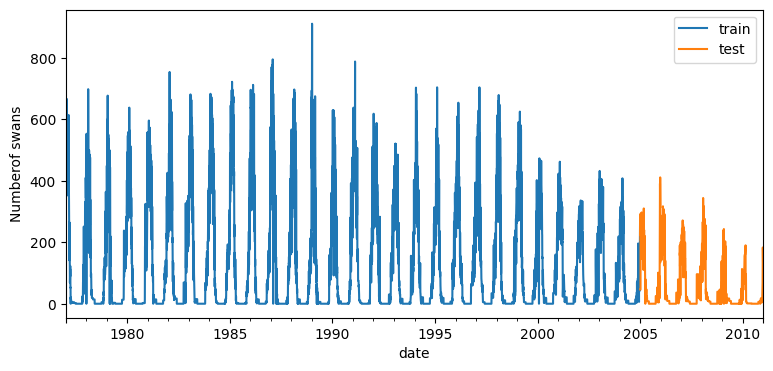

In [9]:


print(f"Train dates : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Test dates  : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

fig, ax=plt.subplots(figsize=(9, 4))
data_train['NumberAM'].plot(ax=ax, label='train')
data_test['NumberAM'].plot(ax=ax, label='test')
ax.set_ylabel('Numberof swans')
ax.legend();

In [18]:
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_estimators=200, max_depth=10),
                lags      = 5000
             )

forecaster.fit(y=data_train['NumberAM'])
forecaster

/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:360: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:360: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10, n_estimators=200, random_state=123) 
Lags: [   1    2    3 ... 4998 4999 5000] 
Transformer for y: None 
Transformer for exog: None 
Window size: 5000 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 10226] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 10, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-10-25 14:16:10 
Last fit date: 2022-10-25 15:06:41 
Skforecast version: 0.5.0 
Python version: 3.10.6 

In [19]:
steps = 365*17
predictions = forecaster.predict(steps=steps)
predictions.head(5)
preds = pd.DataFrame(predictions)

/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:417: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [20]:
first = predictions.index.values[0:]
print(first)
print(len(first))

[ 5000  5001  5002 ... 11202 11203 11204]
6205


In [30]:
print(first)
datetime=[]
for element in first:
    datetime.append(pd.to_datetime(element, unit='D',origin=pd.Timestamp('1991-04-20')))#'1991-04-25'
preds['date'] = datetime
preds.head()

preds = preds.set_index('date')

[ 5000  5001  5002 ... 11202 11203 11204]


In [31]:
preds.head()


,pred
date,
2004-12-27,237.0
2004-12-28,243.0
2004-12-29,247.0
2004-12-30,258.0
2004-12-31,263.0


In [32]:
data_test['NumberAM'].tail()

date
2010-12-22    158
2010-12-23    145
2010-12-24    132
2010-12-25    120
2010-12-26    107
Name: NumberAM, dtype: int64

In [33]:
mask = (preds.index > '2010-12-26')
preds = preds.loc[mask]
preds = preds.round(0)

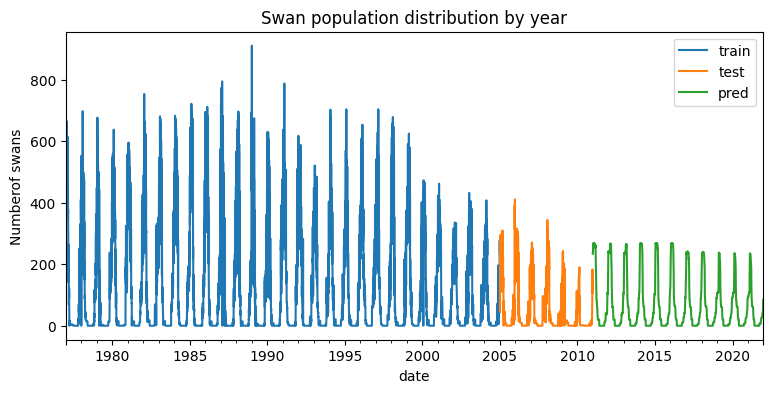

In [34]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['NumberAM'].plot(ax=ax, label='train')
data_test['NumberAM'].plot(ax=ax, label='test')
preds.plot(ax=ax, label='predictions')
ax.set_ylabel('Numberof swans')
ax.set_title('Swan population distribution by year')
ax.legend();

/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:417: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


[ 5000  5001  5002 ... 11202 11203 11204]
6205
[ 5000  5001  5002 ... 11202 11203 11204]


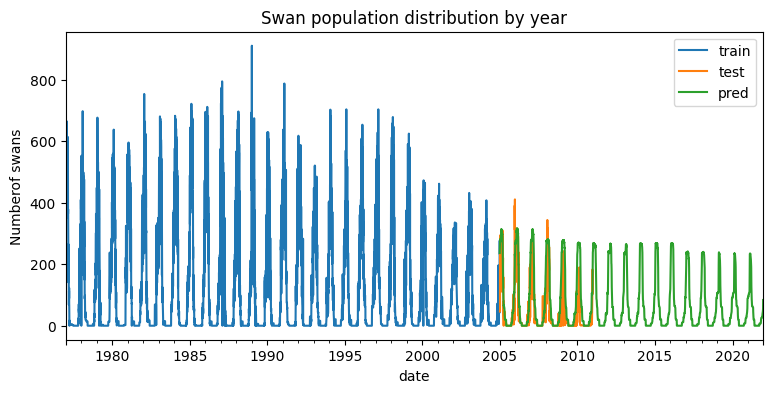

In [35]:
steps1 = 365*5
predictions1 = forecaster.predict(steps=steps)
predictions1.head(5)
preds1 = pd.DataFrame(predictions)
first1 = predictions.index.values[0:]
print(first1)
print(len(first1))
print(first1)
datetime=[]
for element in first1:
    datetime.append(pd.to_datetime(element, unit='D',origin=pd.Timestamp('1991-04-20')))#'1991-04-25'
preds1['date'] = datetime
preds1.head()

preds1 = preds1.set_index('date')
fig, ax = plt.subplots(figsize=(9, 4))
data_train['NumberAM'].plot(ax=ax, label='train')
data_test['NumberAM'].plot(ax=ax, label='test')
preds1.plot(ax=ax, label='predictions')
ax.set_ylabel('Numberof swans')
ax.set_title('Swan population distribution by year')
ax.legend();

In [55]:
data_exp1 = pd.concat(([data_exp, preds]), axis=0)
data_exp1.head()

,pred
date,
1977-01-01,273.0
1977-01-02,273.0
1977-01-03,528.0
1977-01-04,524.0
1977-01-05,519.0


In [56]:
data_exp1.to_csv('data_preds.csv')
preds.to_csv('predictions.csv')
preds.tail()

,pred
date,
2027-12-17,61.0
2027-12-18,61.0
2027-12-19,61.0
2027-12-20,61.0
2027-12-21,61.0


In [57]:
error_mse = mean_squared_error(
                y_true = data_test['NumberAM'],
                y_pred = preds[:2186]
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 4433.455626715462


In [58]:
forecaster.get_feature_importance()

,feature,importance
0,lag_1,0.922155
1,lag_2,0.010405
2,lag_3,0.001883
3,lag_4,0.002557
4,lag_5,0.001209
...,...,...
360,lag_361,0.000758
361,lag_362,0.001384
362,lag_363,0.001197
363,lag_364,0.001223


In [36]:
steps = 2186
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [365, 5000]

# Regressor's hyperparameters
param_grid = {'n_estimators': [50, 100],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['NumberAM'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12.


loop param_grid:   0%|                                              | 0/6 [00:00<?, ?it/s]/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:360: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:360: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:417: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:417: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 22

/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:360: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [40]:
results_grid
#print(results_grid['lags'][4])

,lags,params,mean_squared_error,max_depth,n_estimators
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 50}",9141.283531,10,50
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",9690.750550,3,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",9887.377527,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",9900.364522,5,100
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 50}",10198.416570,3,50
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",10733.216423,5,50
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 50}",10829.912715,10,50
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",11796.769087,10,100
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",20607.567235,5,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 50}",21180.839124,5,50


In [41]:
forecaster1 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123, n_estimators=100, max_depth=10),
                lags      = 365
             )

forecaster1.fit(y=data_train['NumberAM'])
forecaster1

/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:360: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:360: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


ForecasterAutoreg 
Regressor: RandomForestRegressor(max_depth=10, random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 

In [42]:
steps = 2186 +365*17
predictions1 = forecaster1.predict(steps=steps)
predictions1.head(5)
preds1 = pd.DataFrame(predictions1)

/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:417: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [43]:
second = predictions1.index.values[0:]
print(second)
#print(len(second))

[ 365  366  367 ... 8753 8754 8755]


In [44]:
print(second)
datetime=[]
for element in second:    
    datetime.append(pd.to_datetime(element, unit='D',origin=pd.Timestamp('1999-01-01')))
preds1['date'] = datetime
preds1.head()

preds1 = preds1.set_index('date')
preds1.head()

[ 365  366  367 ... 8753 8754 8755]


,pred
date,
2000-01-01,242.896659
2000-01-02,250.771653
2000-01-03,258.797043
2000-01-04,269.233415
2000-01-05,270.674699


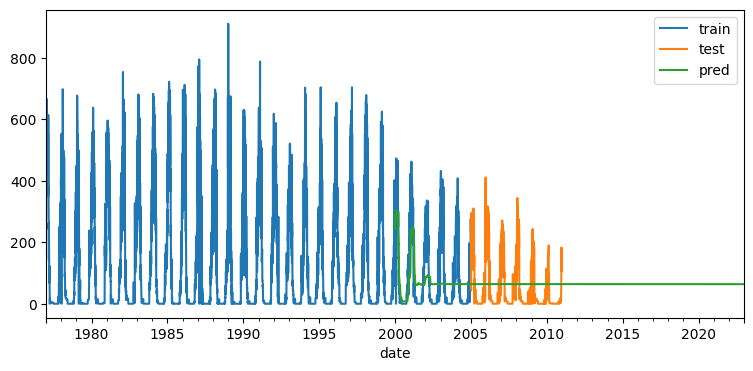

In [45]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['NumberAM'].plot(ax=ax, label='train')
data_test['NumberAM'].plot(ax=ax, label='test')
preds1.plot(ax=ax, label='predictions')
ax.legend();

In [47]:
error_mse = mean_squared_error(
                y_true = data_test['NumberAM'],
                y_pred = preds1[:2186]
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 4754.517556124859


In [48]:
forecaster2 = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 1093
             )

forecaster2.fit(y=data_train['NumberAM'])
forecaster2

/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:360: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


KeyboardInterrupt: 

In [148]:
steps = 4372
predictions2 = forecaster2.predict(steps=steps)
predictions2.head(5)
preds2 = pd.DataFrame(predictions2)

/home/liiva/.local/lib/python3.10/site-packages/skforecast/utils/utils.py:417: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [149]:
third = predictions2.index.values[0:]
print(third)
#print(len(second))

[1093 1094 1095 ... 5462 5463 5464]


In [150]:
print(third)
datetime=[]
for element in third:    
    datetime.append(pd.to_datetime(element, unit='D',origin=pd.Timestamp('1999-01-01')))
preds2['date'] = datetime
preds2.head()

preds2 = preds2.set_index('date')
preds2.head()

[1093 1094 1095 ... 5462 5463 5464]


,pred
date,
2001-12-29,235.87
2001-12-30,243.01
2001-12-31,250.19
2002-01-01,254.29
2002-01-02,255.48


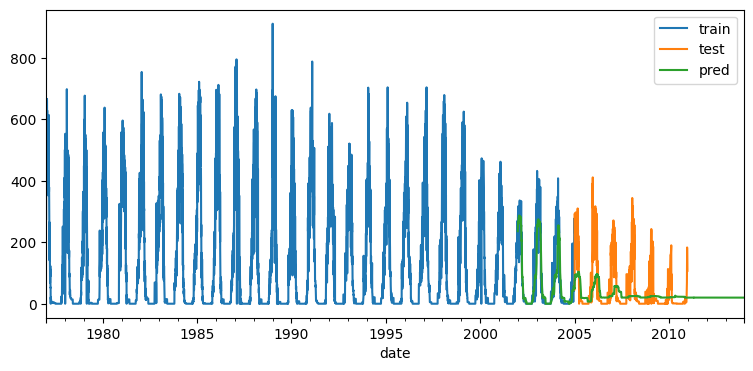

In [151]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['NumberAM'].plot(ax=ax, label='train')
data_test['NumberAM'].plot(ax=ax, label='test')
preds2.plot(ax=ax, label='predictions')
ax.legend();